In [26]:
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
from scipy.signal import convolve2d

In [27]:
image = cv2.imread('red_bird.jpg', cv2.IMREAD_GRAYSCALE)

# Helper function to compute the histogram
def compute_histogram(data, levels=256):
    hist, _ = np.histogram(data.flatten(), bins=levels, range=(0, levels), density=True)
    return hist


def compute_local_means(image, block_size):
    if block_size % 2 == 0:
        block_size += 1
    kernel = np.ones((block_size, block_size), dtype=np.float32) / (block_size * block_size)
    local_means = convolve2d(image, kernel, mode='same', boundary='symmetric')
    return local_means

In [28]:
def optimal_threshold(image, method_type='global', block_size=11):
    height, width = image.shape
    
    if method_type == 'global':
        corner_pixels = np.concatenate([
            image[:5, :5].flatten(),  
            image[:5, -5:].flatten(),  
            image[-5:, :5].flatten(),  
            image[-5:, -5:].flatten()  
        ])
        T = np.mean(corner_pixels)
        delta = 1
        while delta > 0.1:
            foreground = image[image >= T]
            background = image[image < T]
            m1 = np.mean(foreground) if len(foreground) > 0 else T
            m2 = np.mean(background) if len(background) > 0 else T
            T_new = (m1 + m2) / 2
            delta = abs(T_new - T)
            T = T_new
        thresh = np.zeros_like(image, dtype=np.uint8)
        thresh[image >= T] = 255
        return thresh
    
    elif method_type == 'local':
        if block_size % 2 == 0:
            block_size += 1
        
        thresh = np.zeros_like(image, dtype=np.uint8)
        # Use block_size as the step size for non-overlapping blocks
        step = block_size
        
        for i in range(0, height, step):
            for j in range(0, width, step):
                # Define the block boundaries
                y1 = i
                y2 = min(i + block_size, height)
                x1 = j
                x2 = min(j + block_size, width)
                region = image[y1:y2, x1:x2]
                
                # Iterative thresholding for the block
                T = np.mean(region)
                delta = 1
                while delta > 0.1:
                    foreground = region[region >= T]
                    background = region[region < T]
                    m1 = np.mean(foreground) if len(foreground) > 0 else T
                    m2 = np.mean(background) if len(background) > 0 else T
                    T_new = (m1 + m2) / 2
                    delta = abs(T_new - T)
                    T = T_new
                
                # Apply the threshold to all pixels in the block
                block = image[y1:y2, x1:x2]
                thresh[y1:y2, x1:x2][block >= T] = 255
        
        return thresh

In [29]:
# 2. Otsu Thresholding
def otsu_threshold(image, method_type='global', block_size=11):
    height, width = image.shape
    
    if method_type == 'global':
        hist = compute_histogram(image)
        total_pixels = height * width
        hist = hist * total_pixels
        sum_all = np.sum(np.arange(256) * hist)
        sum_b = 0
        w_b = 0
        max_variance = 0
        T = 0
        
        for t in range(256):
            w_b += hist[t]
            if w_b == 0:
                continue
            w_f = total_pixels - w_b
            if w_f == 0:
                break
            sum_b += t * hist[t]
            m_b = sum_b / w_b
            m_f = (sum_all - sum_b) / w_f
            variance = w_b * w_f * (m_b - m_f) ** 2
            if variance > max_variance:
                max_variance = variance
                T = t
        
        thresh = np.zeros_like(image, dtype=np.uint8)
        thresh[image >= T] = 255
        return thresh
    
    elif method_type == 'local':
        if block_size % 2 == 0:
            block_size += 1
        
        # Compute local means using convolution
        local_means = compute_local_means(image, block_size)
        
        T = local_means
        
        # Apply threshold vectorized
        thresh = np.zeros_like(image, dtype=np.uint8)
        thresh[image >= T] = 255
        
        return thresh

In [30]:
def spectral_threshold(image, method_type='global', block_size=11, num_levels=3,offset_range=10):
    height, width = image.shape
    
    if num_levels < 2:
        raise ValueError("Number of levels must be at least 2 (for 1 threshold).")
    
    # Calculate intensity levels (evenly spaced from 0 to 255)
    levels = np.linspace(0, 255, num_levels).astype(np.uint8)
    
    if method_type == 'global':
        pixels = image.flatten().reshape(-1, 1)
        pixels = pixels.astype(np.float32)
        # Initialize clusters at evenly spaced intervals
        centers = np.linspace(0, 255, num_levels, dtype=np.float32).reshape(-1, 1)
        labels = np.zeros(len(pixels), dtype=np.int32)
        for _ in range(10):
            distances = np.abs(pixels - centers[:, np.newaxis])
            labels = np.argmin(distances, axis=0)
            for k in range(num_levels):
                if np.sum(labels == k) > 0:
                    centers[k] = np.mean(pixels[labels == k])
        centers = np.sort(centers.flatten())
        result = np.zeros_like(labels, dtype=np.uint8)
        for k in range(num_levels):
            result[labels == k] = levels[k]
        return result.reshape(height, width)
    
    elif method_type == 'local':
        if block_size % 2 == 0:
            block_size += 1
        half_block = block_size // 2
        thresh = np.zeros_like(image, dtype=np.uint8)

        # Use convolution to compute local means
        local_means = compute_local_means(image, block_size)

        num_thresholds = num_levels - 1
        offsets = np.linspace(-offset_range / 2, offset_range / 2, num_thresholds)

        for i in range(height):
            for j in range(width):
                mean = local_means[i, j]
                thresholds = mean + offsets
                pixel = image[i, j]
                level_idx = 0
                for t in range(num_thresholds):
                    if pixel > thresholds[t]:
                        level_idx = t + 1
                    else:
                        break
                thresh[i, j] = levels[level_idx]
        return thresh


In [31]:
start_time = time.time()
thresh_optimal_global = optimal_threshold(image, method_type='global')
print(f"Optimal Global: {time.time() - start_time:.2f} seconds")

Optimal Global: 0.08 seconds


In [32]:
start_time = time.time()
thresh_otsu_global = otsu_threshold(image, method_type='global')
print(f"Otsu Global: {time.time() - start_time:.2f} seconds")
print(f"Optimal Local: {time.time() - start_time:.2f} seconds")

Otsu Global: 0.03 seconds
Optimal Local: 0.03 seconds


In [33]:
start_time = time.time()
thresh_spectral_global = spectral_threshold(image, method_type='global', num_levels=5)
print(f"Spectral Global: {time.time() - start_time:.2f} seconds")
print(f"Optimal Local: {time.time() - start_time:.2f} seconds")

Spectral Global: 1.62 seconds
Optimal Local: 1.62 seconds


In [34]:
block_size = 21
start_time = time.time()
thresh_optimal_local = optimal_threshold(image, method_type='local', block_size=block_size)
print(f"Optimal Local: {time.time() - start_time:.2f} seconds")

Optimal Local: 0.44 seconds


In [35]:
block_size = 21
start_time = time.time()
thresh_otsu_local = otsu_threshold(image, method_type='local', block_size=block_size)
print(f"Otsu Local: {time.time() - start_time:.2f} seconds")

Otsu Local: 1.96 seconds


In [36]:
block_size = 54
start_time = time.time()
thresh_spectral_local = spectral_threshold(image, method_type='local', block_size=block_size, num_levels=7,offset_range=20)
print(f"Spectral Local: {time.time() - start_time:.2f} seconds")

Spectral Local: 21.49 seconds


(-0.5, 2033.5, 1285.5, -0.5)

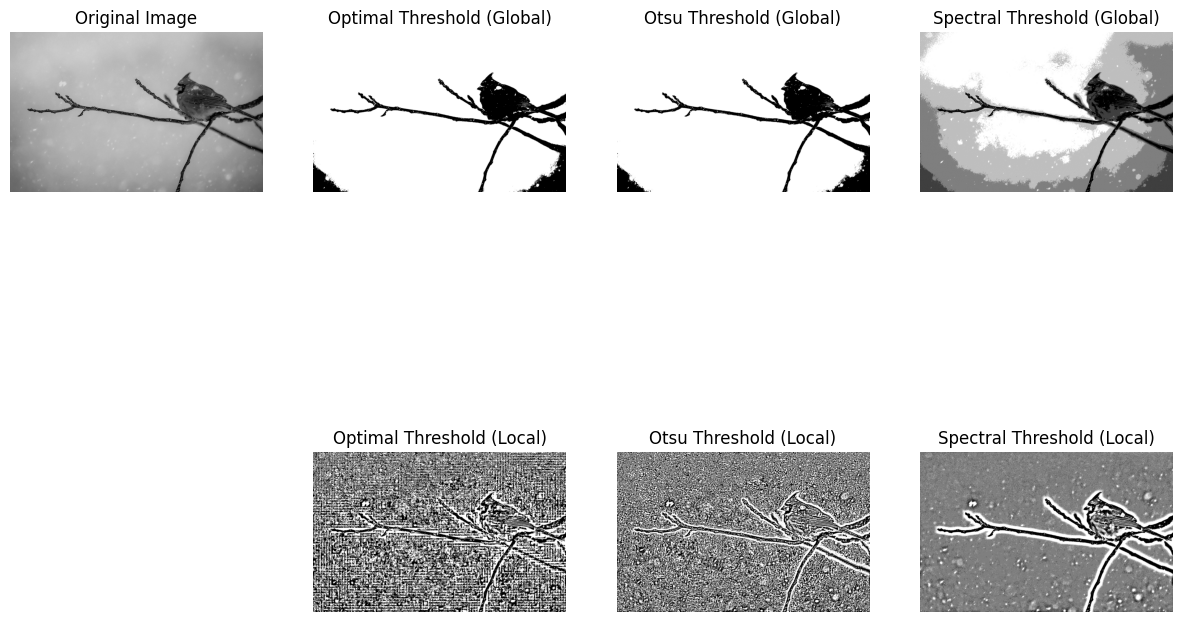

In [37]:
# # # Display the results
plt.figure(figsize=(15, 10))

plt.subplot(241)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(242)
plt.title("Optimal Threshold (Global)")
plt.imshow(thresh_optimal_global, cmap='gray')
plt.axis('off')

plt.subplot(243)
plt.title("Otsu Threshold (Global)")
plt.imshow(thresh_otsu_global, cmap='gray')
plt.axis('off')

plt.subplot(244)
plt.title("Spectral Threshold (Global)")
plt.imshow(thresh_spectral_global, cmap='gray')
plt.axis('off')

plt.subplot(246)
plt.title("Optimal Threshold (Local)")
plt.imshow(thresh_optimal_local, cmap='gray')
plt.axis('off')

plt.subplot(247)
plt.title("Otsu Threshold (Local)")
plt.imshow(thresh_otsu_local, cmap='gray')
plt.axis('off')

plt.subplot(248)
plt.title("Spectral Threshold (Local)")
plt.imshow(thresh_spectral_local, cmap='gray')
plt.axis('off')